Code in support for paper:

-----
Radu Dogaru, Ioana Dogaru, "LB-CNN: An Open Source Framework for Fast Training of Light Binary Convolutional Neural Networks using Chainer and Cupy",
submitted IEEE Trans. on Industry Applications. 

Allows to optimize / train a binary convolutional compact NL-CNN model. 
------

Copyright Radu & Ioana DOGARU, May 2021  


#Cell 0 - reads the available GPU 

In [1]:
# CELL 0 - DETAILS ABOUT THE AVAILABLE GPU 
!nvidia-smi

Tue Jun 15 13:31:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Run this cell if CHAINER / CUPY are not installed on your platform 
!pip install 'cupy-cuda101>=7.7.0,<8.0.0'
!pip install chainer

     |████████████████████████████████| 370.3MB 45kB/s 
  Found existing installation: cupy-cuda101 9.1.0
    Uninstalling cupy-cuda101-9.1.0:
      Successfully uninstalled cupy-cuda101-9.1.0
     |████████████████████████████████| 1.0MB 24.9MB/s 
  Created wheel for chainer: filename=chainer-7.8.0-cp37-none-any.whl size=967735 sha256=bac7df19e598ed659a7c1de3bab0a209d30950339592b1e0afc55d9cc5896fd8
  Stored in directory: /root/.cache/pip/wheels/9e/2a/68/e29d17f2a8febda6d531a52b595416cb1b6df1b2be02610fed
Successfully built chainer


# Cell 1 a  (Reads the ORL dataset)

In [3]:
# CELL 1a - loading a specific dataset 
# ---- CELLS of type 1a can be added for specific datasets 

# Here datasets from SKLEARN - here the ORL Face recognition 
# with possibility to select the fraction for training 
#--------------------------------------------------------
k1=250     # Training samples 
toate=400  # All images 
#---------------------------------------------------------
import tensorflow as tf
from sklearn import datasets as dat
import numpy as np
e=dat.fetch_olivetti_faces(data_home=None, shuffle=True, random_state=0, download_if_missing=True)


x_train=e.images[0:k1,:,:]
x_test=e.images[k1:toate,:,:]
y_train=e.target[0:k1]
y_test=e.target[k1:toate]

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST  
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1]) 
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] ) 
# place a  1 in the end to keep it compatible with kernel in conv2d 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train=np.reshape(y_train, [np.shape(y_train)[0], 1]) 
y_test=np.reshape(y_test, [np.shape(y_test)[0], 1] ) 
num_classes=np.max(y_train)+1

y_train_nc=y_train  #-----------------------------------------
y_test_nc=y_test  # keep non-categorical version for ELM training 

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
inp_chan=np.shape(x_train)[3]
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


# Cell 1 b  (Reads other, medium-sized datasets: MNIST, CIFAR, F-MNIST )
When using the fast optimizer (cells 2-6) use reduced=10000 here to avoid GPU-RAM overflow 

In [ ]:
# CELL 1B 
# Datasets from Keras - MNIST, F_MNIST, CIFAR 
#---------------------------------------------------
# In the kernel optimization phase a small number of training samples must be considered. 
# After optimization re-run the cell to load the entire data set  
#------------------------------------------------------------------------
dataset='cifar10' # mnist or f-mnist or cifar10 
reduced=10000  # Use as little as possible to accomodate the available GPU RAM 
#------------------------------------------------------------------------------------

import numpy as np
import tensorflow as tf

 
dformat='channels_last'

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist

if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # incarca date nescalate 
elif  dataset=='cifar10': 
    (x_train, y_train), (x_test, y_test) = cifar10.load_data() # incarca date nescalate 
elif  dataset=='cifar100': 
    (x_train, y_train), (x_test, y_test) = cifar100.load_data() # incarca date nescalate 
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST  
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1]) 
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] ) 
# place a  1 in the end to keep it compatible with kernel in conv2d 
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255 
inp_chan=np.shape(x_train)[3] 
print('Number of input channels in image:', inp_chan)
num_classes=np.max(y_train)+1
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]

y_train_nc=y_train  #-----------------------------------------
y_test_nc=y_test  # Keep non-categorical version for ELM training  


if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
    y_train_nc=y_train
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#----------------------------------------------------------------------------


Number of input channels in image: 3


# Cell 2  ( Moves data on GPU for fast optimization and training  ). 
Run only after loading a new dataset and if Cupy/ Chainer optimizer is used

In [4]:
# CELL 2 - Must run when for CUPY/CHAINER implementation 
#---------  converts datasest into Chainer format and puts them on GPU 

import time as ti 
import cupy as cp
import chainer 
from chainer.functions import convolution_2d, depthwise_convolution_2d, relu, flatten, max_pooling_2d, reshape
chainer.configuration.config.cudnn_deterministic=True  
chainer.using_config('autotune',True)

xc_train=np.moveaxis(x_train,3,1)
xc_test=np.moveaxis(x_test,3,1)
# move on GPU 
xc_train_g=cp.asarray(xc_train)
xc_test_g=cp.asarray(xc_test)

c_in=np.size(xc_train,1)
print('===============  input data =========================================')
print('Channels in input image: ',c_in)
print('Size of raw input samples:', np.size(xc_train,2),'x',np.size(xc_train,3))
print('Number of training samples: ',np.size(xc_train,0))



/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda101) version 9.1.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda101>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


===============  input data =========================================
Channels in input image:  1
Size of raw input samples: 64 x 64
Number of training samples:  250


# Cell 4  (Relevant functions for the Chianer/Cupy fast optimizer)
Run only once. 

In [5]:
# CELL 4 - defines functions for the BNL-CNN with CUPY ELM training 
#---------------------------------------------------------------------
#  Useful functions and imports 
#------------------------------------------------
#  Next:  CUPY - ELM (very fast training when data is already on GPU) 
# ================================================================


def hidden_nonlin(hid_in, tip):
# implementation of the hidden layer 
# additional nonlinearitys may be added 
    if tip==0: 
        # sigmoid 
        H=cp.tanh(hid_in)        
    elif tip==1:
        # linsat 
        H=cp.abs(1+hid_in)-cp.abs(1-hid_in)
    elif tip==2:
        # ReLU
        H=cp.abs(hid_in)+hid_in
    elif tip==3:
        #  very well suited for emmbeded systems 
        H=cp.abs(hid_in)
    elif tip==4:
        H=cp.sqrt(hid_in*hid_in+1)
        # multiquadric 
    elif tip==5:
        H=cp.sign(hid_in)
        # multiquadric
    return H
        
# ELM training 
def elmTrain_optim(X, Y, h_Neurons, C , tip):
# Training phase - floating point precision (no quantization)
# X - Samples (feature vectors) Y - Labels
      Ntr = cp.size(X,1)
      in_Neurons = cp.size(X,0)
      classes = cp.size(Y,0)
      
      #   Generate inW layer  
      if h_Neurons>0:
          rnd = cp.random.RandomState()
          inW=-1+2*rnd.rand(h_Neurons, in_Neurons).astype('float32')
          
          #inW=cp.dot(inW,CO)
          #  Compute hidden layer 
          hid_inp = cp.dot(inW, X)
          H=hidden_nonlin(hid_inp,tip)
      elif h_Neurons==0:
          inW=cp.asarray([])
          h_Neurons=in_Neurons
          H = X
      
      # Moore - Penrose computation of output weights (outW) layer 
      if h_Neurons<Ntr:
          print('LLL - Less neurons than training samples')
          outW = cp.linalg.solve(cp.eye(h_Neurons)/C+cp.dot(H,H.T), cp.dot(H,Y.T))     
      else:
          print('MMM - More neurons than training samples')
          outW = cp.dot(H,cp.linalg.solve(cp.eye(Ntr)/C+cp.dot(H.T,H), Y.T))
      return inW, outW 


# implements the ELM training procedure with weight quantization       
def elmTrain_fix( X, Y, h_Neurons, C , tip, ni):
# Training phase - emulated fixed point precision (ni bit quantization)
# X - Samples (feature vectors) Y - Labels
# ni - number of bits to quantize the inW
      Ntr = cp.size(X,1)
      in_Neurons = cp.size(X,0)
      classes = cp.size(Y,0)
    
      #   Generate inW layer  
      if h_Neurons>0:
          rnd = cp.random.RandomState()
          inW=-1+2*rnd.rand(h_Neurons, in_Neurons).astype('float32')
          #inW=rnd.randn(nHiddenNeurons, nInputNeurons).astype('float32')
          Qi=-1+pow(2,ni-1) 
          inW=cp.round_(inW*Qi)
          #  Compute hidden layer 
          hid_inp = cp.dot(inW, X)
          H=hidden_nonlin(hid_inp,tip)
      elif h_Neurons==0:
          inW=cp.asarray([])
          h_Neurons=in_Neurons
          H = X     
      # Moore - Penrose computation of output weights (outW) layer 
      if h_Neurons<Ntr:
          print('LLL - Less neurons than training samples')
          outW = cp.linalg.solve(cp.eye(h_Neurons)/C+cp.dot(H,H.T), cp.dot(H,Y.T))     
      else:
          print('MMM - More neurons than training samples')
          outW = cp.dot(H,cp.linalg.solve(cp.eye(Ntr)/C+cp.dot(H.T,H), Y.T))
     
      return inW, outW 
      
# ELM predict  (using a model defined by: [inW, outW, tip])
def elmPredict_optim( X, inW, outW, tip, ts_Labels):
# implements the ELM predictor given the model as arguments 
# model is given by inW, outW and tip 
# returns a score matrix (winner class has the maximal score)
#------------ 28 mai 2021 - computes accuracies and predicted labels 


      if cp.size(inW)==0: 
        H=X
        
      else: 
        hid_in=cp.dot(inW, X)
        H=hidden_nonlin(hid_in,tip)
      #print('aspect:',np.shape(H))
      score = np.transpose(cp.dot(cp.transpose(H),outW))
      pred=1+cp.argmax(score, axis=0) # predicted labels (min =1)
      # Given the ts_Labels one may compute accuracy 
      correct=cp.count_nonzero(pred==ts_Labels)
      Ns=np.shape(cp.asnumpy(ts_Labels))[1]
      acc=correct/Ns
      
      return pred, acc 
        
# Binary kernles generator - supports the NL-CNN model with depthwise_convolution 
# 

def ker_gen_x(c_in,nf1,nf2,nf3, nl, convs):   # 
    kers=[]
    ker=cp.sign(cp.random.rand(nf1, c_in, 3, 3).astype('float32')-0.5)
    kers.append(ker)
    if nl[0]>1:
      for k in range(-1+nl[0]):
        ker=cp.sign(cp.random.rand(1, c_in*nf1, 3, 3).astype('float32')-0.5)
        kers.append(ker)


    # --------- LAYER 2 ----------------------   
    if convs>1: 
      ker=cp.sign(cp.random.rand(nf2, nf1*c_in, 3, 3).astype('float32')-0.5)
      kers.append(ker)
      if nl[1]>1:
        for k in range(-1+nl[1]):
          ker=cp.sign(cp.random.rand(1, c_in*nf1*nf2, 3, 3).astype('float32')-0.5)
          kers.append(ker)
  
    # ---- LAYER 3 ----------------------
    if convs>2:
      ker=cp.sign(cp.random.rand(nf3, nf2*nf1*c_in, 3, 3).astype('float32')-0.5)
      kers.append(ker)
    return kers

# Define the NL_CNN model with (binary) kernels previously generated or learned 

def my_model(inpdata, nl, convs, kers):  # Implements the nonlinear model NL-CNN 
    
    str1=2 # Same strides on all layers 
    #print('Strat 1')
    net=depthwise_convolution_2d(inpdata, kers[0], pad=1)
    #print('Index: ',0)
    if nl[0]>1:
      for k in range(-1+nl[0]):
        net=relu(net)
        net=depthwise_convolution_2d(net, kers[k+1], pad=1)
        #print('Index: ',k+1)
    net=max_pooling_2d(net,ksize=4,stride=str1, pad=1, cover_all=True)
    if convs>1: 
      #------------- second macro-layer 
      #print('Strat 2')
      net=depthwise_convolution_2d(net, kers[nl[0]], pad=1)
      #print('Index: ',nl[0])
      if nl[1]>1:
        for k in range(-1+nl[1]):
          net=relu(net)
          #print('Index: ',k+1+nl[0])
          net=depthwise_convolution_2d(net, kers[k+1+nl[0]], pad=1)
        
    
      net=max_pooling_2d(net,ksize=4,stride=str1, pad=1, cover_all=True)
    if convs>2:
      # ---------- 3'd macrolayer 
      #print('Strat 3')
      #print('Index: ',nl[0]+nl[1])
      net=depthwise_convolution_2d(net, kers[nl[0]+nl[1]], pad=1)
      net=max_pooling_2d(net, ksize=4,stride=str1, pad=1, cover_all=True)
    shp=np.shape(net)
    # -- FLATTEN + ELM style input conversion 
    perm=(0,2,3,1)  # Permute for compatibility with TF/Keras models  
    net=reshape(net.transpose(perm),(shp[0],shp[1]*shp[2]*shp[3]))
    print(shp)
    return net


# Cell 5  (Initialize the loop process in cell 6)
Run when a new optimization loop (Running Cell 6 for several trials) starts

In [6]:
# CELL 5 - Run only once before starting random binary kernel trials with CELL 6 
#----------------------------------------------------
# Run this cell at the beginning of the optimization process

All=np.zeros(0)  # DO The next cell until the best performance (accuracy) is acceptable 
best_ac=0

# Then run next cell as many trials are needed to improve performance 


# Cell 6 (Defines LB-CNN model optimzie and train the ELM output)
Each running is a trial. Run cell 6 with **use_stored=0** as many times (trials) as needed to improve accuracy. 

When the accuracy is convenient run cell 6 again using **use_stored=1** 

In [16]:
# CELL 6 
# -- Run as many trials as needed to improve the ELM0 accuracy 
# then put use_stored=1 and run again for best kernels (bk)

# CUPY/CHAINER model with random kernels at each stage !
# Run several times to improve the accuracy 
#--------------------------------------------------------------------------------------
use_stored=1  # 0 = uses random kernles ; 1 - uses the bk (best solution found during the trials)
conv_layers=2 # convolution layers - 
nf1=5; nf2=4; nf3=2 # filers in conv layers  
# Here the filters for the depthwise model only 
NL=(1,1) # Nonlinearity for the NL-CNN model 

#----------- ELM setup ----------------------------------
nr_neuroni=0 # 0 = ELM0 (with no hidden layer)
C=0.0010  
tip=3 # Neliniaritate strat ascuns (0-tanh, 1-linsat, 2-ReLu, 3- abs(), 4-multiquad, 5 sign() )  
nb_in=2;  # 0 = float; >0 = nr. biti cuantizare ponderi strat intrare 
nb_out=8; # 0 = float; >0 = output layer fixed point quantization 


# GENERATE KERNLES (BINARY)
if use_stored==0:
  kers=ker_gen_x(c_in, nf1, nf2, nf3, NL, conv_layers)
else: 
  kers=bk 

# ----------------------- IMPLEMENT CONV LAYERS ON TRAIN SET

t1=ti.time()
net=my_model(xc_train_g, NL, conv_layers, kers)

# Conversion of data in ELM format  
Samples_g=chainer.variable.as_array(net.T)
Labels=np.reshape(y_train_nc+1,(1,np.shape(y_train_nc)[0]))
Y=2*y_train.T-1
t2=ti.time(); print('Train set convolution time:', t2-t1,' seconda')
# ----------------------- IMPLEMENT CONV LAYERS ON TEST SET
t1=ti.time()
net=my_model(xc_test_g, NL, conv_layers, kers)

# Conversie pe CP var NUMPY 
ts_Samples_g=chainer.variable.as_array(net.T)
ts_Labels=np.reshape(y_test_nc+1,(1,np.shape(y_test_nc)[0]))
t2=ti.time(); print('Test set convolution time', t2-t1,' seconds')

clase=np.max(Labels); print('Classes: ',clase)
out_conv=np.shape(net)[1]
print('===============  convolved data =========================================')
print('Size of the output, convolved layer (nout): ',out_conv)
print('===============Now ELM training ===============================================')



Labels_g=cp.asarray(Labels)
Y_g=cp.asarray(Y)
ts_Labels_g=cp.asarray(ts_Labels)

#-------------------------------------------------------------------
# ELM running  
import time as ti 

#================= TRAIN ELM =====================================================
t1 = ti.time()
if nr_neuroni==0:
    nb_in=0
if nb_in>0:
    inW, outW = elmTrain_fix(Samples_g, Y_g, nr_neuroni, C, tip, nb_in)
else:
    inW, outW = elmTrain_optim(Samples_g, Y_g, nr_neuroni, C, tip)
trun = ti.time()-t1
print(" training time: %f seconds" %trun)

# ==============  Quantify the output layer ======================================
Qout=-1+pow(2,nb_out-1)
if nb_out>0:
     O=cp.max(cp.abs(outW))
     outW=cp.round_(outW*(1/O)*Qout)

del Samples_g
#====================== VALIDATION PHASE (+ Accuracy evaluation) =================
t1 = ti.time()
(pred_g, acc_g) = elmPredict_optim(ts_Samples_g, inW, outW, tip, ts_Labels_g)
trun = ti.time()-t1
print( " prediction time: %f seconds" %trun)
print('ELM latency',1e6*trun/np.shape(ts_Labels)[1],' us')
accuracy=cp.asnumpy(acc_g)

print('----------------------------------------------------------')
print('|              Accuracy is: ', 100*acc_g, '%             |')
print('----------------------------------------------------------')

print('===========Structure information ===============================')
szk=len(kers)
kbits=0
for ii in range(szk):
  kbits+=np.prod(np.shape(cp.asnumpy(kers[ii])))
print('CONV: Number of bits in convolutional kernels: ', kbits)
print('OUTP: Number of its in the output layer - ELM0: ', 8*clase*out_conv)

print( "Number of hidden neurons: %d" %nr_neuroni)
#print( "Hidden nonlinearity (0=sigmoid; 1=linsat; 2=Relu; 3 - ABS; 4- multiquadric): %d" %tip)
print('Number of conv filters:  as follows: conv_layers:',conv_layers,' nf1:', nf1,' nf2: ', nf2, 'nf3: ',nf3 ) 
#print('C= ',C)   

#====================================================================================   
if accuracy>best_ac:
  best_ac=accuracy
  best_outw=outW
  # update bk 
  print('Bk updated')
  bk=kers

All=np.append(All, accuracy)

(250, 20, 16, 16)
Train set convolution time: 0.0018644332885742188  seconda
(150, 20, 16, 16)
Test set convolution time 0.003535032272338867  seconds
Classes:  40
===============  convolved data =========================================
Size of the output, convolved layer (nout):  5120
===============Now ELM training ===============================================
MMM - More neurons than training samples
 training time: 0.001623 seconds
 prediction time: 0.013670 seconds
ELM latency 91.13152821858723  us
----------------------------------------------------------
|              Accuracy is:  100.0 %             |
----------------------------------------------------------
===========Structure information ===============================
CONV: Number of bits in convolutional kernels:  225
OUTP: Number of its in the output layer - ELM0:  1638400
Number of hidden neurons: 0
Number of conv filters:  as follows: conv_layers: 2  nf1: 5  nf2:  4 nf3:  2


# Auxiliarry cell: run to see the accuracies in all previous trials

1.0
0.9466666666666667
(45,)
Best accuracy is"::  1.0


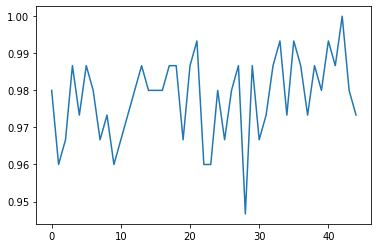

In [ ]:
# Run this cell to show the progress of CUPY-ELM training 

print(np.max(All))
print(np.min(All))
print(np.shape(All))
import matplotlib.pyplot as plt
plt.plot(All)
print('Best accuracy is":: ', best_ac)

# Cell 7 - Define the Keras model for further embbeding of the non-standard LB-CNN model from above (defined by bk and outW) 
Run only once

In [17]:
# CELL 7 - Defining a KERAS / TF Model 
#---------------------------------------------
# Define a L-CNN base model (template to cast the BL-CNN optimized version)

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling 
from keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam

def create_l_cnn_base_model(input_shape, filtre1=10, filtre2=10, filtre3=10, flat=1, nl=(1,1), convs=3, num_clase=10):
  # convs - cate straturi convolutionale sunt implementate 
  # Arguments: k - multiplication coefficient 
 
  csize1=3; csize2=3 ; csize3=3      # convolution kernel size (square kernel) 
  psize1=4; psize2=4 ; psize3=4      # pooling size (square)
  str1=2; str2=2; str3=2             # stride pooling (downsampling rate) 
  pad='same'; # padding style ('valid' is also an alternative)
  type_conv=1
  
  model = Sequential()
  #================= LAYER 1 ========================================================
  if type_conv==2:
        model.add(Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape))
  elif type_conv==1:
        model.add(DepthwiseConv2D(kernel_size=csize1, padding=pad, input_shape=input_shape, depth_multiplier=filtre1, use_bias=False))
        # partea de mai jos emuleaza nl-cnn
        if nl[0]>1:
          for k in range(nl[0]-1): 
            model.add(Activation('relu'))
            model.add(DepthwiseConv2D(kernel_size=csize1, padding=pad, depth_multiplier=1, use_bias=False))
 
  model.add(MaxPooling2D(pool_size=(psize1, psize1),strides=(str1,str1),padding=pad))
  if convs>1: 
  #================= LAYER 2 ========================================================
    if type_conv==2:
        model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
    elif type_conv==1:
        model.add(DepthwiseConv2D(kernel_size=csize2, padding=pad, depth_multiplier=filtre2, use_bias=False))
        # Partea de mai jos -- nl=2 
        if nl[1]>1:
          for k in range(nl[1]-1): 
            model.add(Activation('relu'))
            model.add(DepthwiseConv2D(kernel_size=csize3, padding=pad, depth_multiplier=1, use_bias=False))
       
        #model.add(Activation('relu'))
        #model.add(DepthwiseConv2D(kernel_size=csize2, padding=pad, depth_multiplier=1, use_bias=False))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(psize2, psize2),strides=(str2,str2),padding=pad))
  if convs>2:
  #================= LAYER 3 ========================================================
    if type_conv==2:
        model.add(Conv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) )
    elif type_conv==1:
        model.add(DepthwiseConv2D(kernel_size=csize3, padding=pad, depth_multiplier=filtre3, use_bias=False))
  #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
  #================= out 
  if flat==1:
      model.add(Flatten())  # 
  elif flat==0:
      model.add(GlobalAveragePooling2D()) # Global average 
  # Output dense layer  
  model.add(Dense(num_clase,activation='softmax'))
  return model


#Cell 8 Convert the non-standard LB-CNN model into a Keras model with weights in convolutional layers frozen
Use **randk=0**; If **randk=1** one can simply generate a random binary weights LB-CNN model for further Keras training.

In case of randk=1 the model is specified in lines 18-20

In [18]:
# CELL 8 - IMPLEMENT THE MODEL AND DO THE TRANSFER (if randk=0) from the ELM-trained CUPY/CHAINER model 
# IF randk=1 A BINARY CNN MODEL IS GENERATED  

#-------------------------------------------------------------------------------
# Create a base model with binary non-trinable weights optimized via Cupy ELM 
# bk is used to load the kernel weights 

import numpy as np
import tensorflow as tf
import keras
trainable=False

#--- if commented they are defined in ELM-CUPY section above 
# uncomment
randk=0 # Choose 0 to load the optimzed bk from CUPY-ELM training ( if =1 -> random binary )
if randk==1:
  # Ignores any ELM-CUPY-training
  NL=(1,1)
  (nf1,nf2,nf3)=(10,6,2)
  conv_layers=2

model=create_l_cnn_base_model(input_shape, nf1, nf2, nf3, flat=1, nl=NL, convs=conv_layers, num_clase=num_classes)


allw=model.get_weights()
nr=NL[0]
if conv_layers>1:
  nr=nr+NL[1] 
if conv_layers>2:
  nr=nr+1


ballw=allw # preparing weights for binarization 
for i in range(nr):
  print('Layer: ',i,' weight shape', np.shape(allw[i]), 'Min: ',np.min(allw[i]), 'Max: ',np.max(allw[i]))
  s1=np.shape(allw[i])
  tsize=np.shape(np.shape(allw[i]))[0]
  #print(np.shape(tsize))
  if trainable==False:
    if tsize == 4: # Convolutional layer 
      # Kernels bk - saved previously 
      if  randk==0: 
        kerns=cp.asnumpy(bk[i])
        kkers=kerns.transpose(2,3,1,0) # Compatibility issue (Chainer -- Keras)
        print('Shape Kers: ', np.shape(kkers))
        ballw[i]=kkers
        print('Shape ballw', np.shape(ballw[i]))
      elif randk==1:
        ballw[i]=np.sign(np.random.rand(s1[0],s1[1],s1[2],s1[3])-0.5)
    elif tsize== 1: # It's not the case for depthwise 
      ballw[i]=np.sign(np.random.rand(s1[0])-0.5)


  print('-------- Layer: ',i,' weights shape', np.shape(ballw[i]), 'Min: ',np.min(ballw[i]), 'Max: ',np.max(ballw[i]))


model.set_weights(ballw)

# This is needed in TF2.5. 
inp_shape=(None, input_shape[0], input_shape[1], input_shape[2] )   # Needed in TF2.5 
model.build(input_shape=inp_shape)



#------------ transfer ELM trained weights to the output layer 
if randk==0:
  bp=model.get_weights()
  print(np.shape(bp[nr]))
  bp[nr]=(1/1000)*cp.asnumpy(outW)
  bp[nr+1]=0*bp[nr+1]   # Bias is 0 
  model.set_weights((bp))

#-------------------------------------------
if randk==1 :
  lr=0.001
else:
  lr=0.00001

myopt = Adam(learning_rate=lr)
#myopt= RMSprop(learning_rate=0.00001)

  # --------------------------   LOSS function  ------------------------------------
my_loss='categorical_crossentropy'
model.compile(loss=my_loss, 
              optimizer=myopt,   # any other optimization 
              metrics=['accuracy'])

# If trainable=False - Makes all layers except the last non-trainable (to store binary weights)  
nrlayers=len(model.layers)
if trainable==False:

  for i in range(nrlayers-1):
      model.layers[i].trainable=False


model.summary()


Layer:  0  weight shape (3, 3, 1, 5) Min:  -0.33212885 Max:  0.3302411
Shape Kers:  (3, 3, 1, 5)
Shape ballw (3, 3, 1, 5)
-------- Layer:  0  weights shape (3, 3, 1, 5) Min:  -1.0 Max:  1.0
Layer:  1  weight shape (3, 3, 5, 4) Min:  -0.2712606 Max:  0.2717921
Shape Kers:  (3, 3, 5, 4)
Shape ballw (3, 3, 5, 4)
-------- Layer:  1  weights shape (3, 3, 5, 4) Min:  -1.0 Max:  1.0
(5120, 40)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d (DepthwiseC (None, 64, 64, 5)         45        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 5)         0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 32, 32, 20)        180       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 20)        0      

#Cell 9 (auxiliary): Evaluate the Keras model on the test set

In [19]:
# CELL 9 - Evaluate the accuracy of the model 
# If OK skip to cell 12 and save the model 
# Else - additional Keras/Tensorflow training follows (eventually using the entire dataset)

score=model.evaluate(x_test, y_test)
print(score)



5/5 [==============================] - 42s 9ms/step - loss: 0.0339 - accuracy: 1.0000
[0.028320852667093277, 1.0]


#Cell 10 - Additional training of the output layer using Keras optimizers. 
It is useful to reload the full dataset (Cell 1, reduced=0) 

/ 0 epoch lasted  2.8536946773529053  seconds
Improved in epoch: 0  New accuracy:  100.0 %
/ 1 epoch lasted  0.18336963653564453  seconds
/ 2 epoch lasted  0.1940295696258545  seconds
/ 3 epoch lasted  0.3440132141113281  seconds
/ 4 epoch lasted  0.22236919403076172  seconds
/ 5 epoch lasted  0.18373775482177734  seconds
/ 6 epoch lasted  0.3437309265136719  seconds
/ 7 epoch lasted  0.18847250938415527  seconds
/ 8 epoch lasted  0.17870593070983887  seconds
/ 9 epoch lasted  0.34601664543151855  seconds
Best accuracy: 100.0 % reached in epoch:  0  running   10  epochs lasts  5.60452127456665  seconds
Total number of parameters:  205065
Test accuracy: 1.0
Time for test set :  0.05387401580810547
Latency (per input sample): 0.3591601053873698 ms


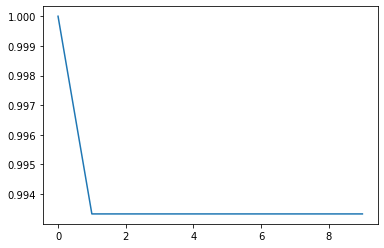

In [20]:
# CELL 10 
#-------------------------------------------------------------------
# Additional training - if needed 
# Typically improves the accuracy even for the reduced train set 
# Loading the full dataset and training provides the best performance 
#-----------------  for reproductibility  ----------------------
import tensorflow as tf 
import keras
import numpy as np # linear algebra
import keras.backend as K 

import time as ti 
import scipy.io as sio
import matplotlib.pyplot as plt

#=====================================================================
batch_size = 10  # useful for MNIST, CIFAR, for ORL take 1  ( eg.50-200 large datasets - 1/1000 train set typicall)
epoci = 10 # maximal number of training epochs (the best result may be obtained earlier)
train_style = 2 # 1-standard Keras (not recommended) ; 2 epoch by epoch and keeping best test accuracy until "epoci"; 
#-------------- 
augment=0
first_time=1

if first_time==1:
  best_acc=0.0; best_ep=0
else:
  from keras.models import load_model
  best_acc=0.6
  model=load_model('B-nlcnn_gtrsb_88_59.h5')
  #model.summary()
# ---------------------- For some date augmetation may help  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
if augment==1:
  data_generator = ImageDataGenerator(
                        ### --- useful for FER2013 ---
                                      
                          featurewise_center=False,
                          featurewise_std_normalization=False,
                          rotation_range=10,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          zoom_range=.1,
                          horizontal_flip=True 
                          )
  
                        #------- useful for CIFAR10 according to https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-
elif augment==2:
  data_generator = ImageDataGenerator(
                          rotation_range=15,
                          horizontal_flip=True,
                          width_shift_range=0.1,
                          height_shift_range=0.1
                        #------------------------------
                         )
elif augment==3:      # Proposed  in https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb
  data_generator = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)


#=========================================================================================
err_test=np.zeros(epoci)   # For plotting test error evolution  
t1=ti.time()
for k in range(epoci):
      tx=ti.time()
      # No augmentation 
      if augment==0:
        model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=1,
              verbose=0,  # aici 0 (nu afiseaza nimic) 1 (detaliat) 2(numai epocile)
              validation_data=(x_test, y_test))
        
        # ---- Next lines to ensure the model is binary 
        # although conv layer are set Non-Trainable there is a small update there 
        bpt=model.get_weights()
        #--- next lines ensure binary conv. values 
        last_layer=len(bpt)
        for kz in range(last_layer-2):
              bpt[kz]=np.sign(bpt[kz])
        model.set_weights(bpt)
        
       #-----------------------------------------------
      elif augment>0:
        # Augmented data 
          model.fit_generator(data_generator.flow(x_train, y_train,
              batch_size=batch_size),
              epochs=1,shuffle=False, 
              verbose=0,  # no display 
              validation_data=(x_test, y_test))
              #,callbacks=callbacks)        
      ty=ti.time()
      print('/',k,'epoch lasted ',ty-tx,' seconds')
      
      score = model.evaluate(x_test, y_test, verbose=0)

      err_test[k]=score[1]
      if score[1]>best_acc : 
            print('Improved in epoch:', k, ' New accuracy: ', 100*score[1],'%')
            best_acc=score[1]
            best_ep=k
            bp=model.get_weights()
            
t2=ti.time()
print('Best accuracy:', best_acc*100, '% reached in epoch: ',best_ep, ' running  ',epoci,' epochs lasts ',t2-t1,' seconds')
plt.plot(err_test)
model.set_weights((bp)) # evaluete prediction time on all test samples
t1=ti.time()
score = model.evaluate(x_test, y_test, verbose=0)
t2=ti.time()
print ('Total number of parameters: ',model.count_params())
print('Test accuracy:', score[1])
print ('Time for test set : ',t2-t1)
print('Latency (per input sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')


In [ ]:
import gc
gc.collect()
# Can be used to free some RAM 

24138

#Cell 11 - Fixed-point quantization of the output layer
Try various **nb_out** values in order to obtain simillar accuracy to that prodeced in Cell 10 (using float32 weights in the output layer) 

In [23]:
# CELL 11 - FIXED POINT QUANTIZATION OF THE OUTPUT DENSE LAYER 
#---------------------------------------------------------------
# QMLP0 (quantified MLP0 module)
# Quantization of the above resulted model (only for MLP0)
# Copyright Radu and Ioana DOGARU;  
#=============================================================
nb_out=11  # Quantization factor (bits per weight)
#-------------------------------------------------------------------
outWx=bp.copy()
Qout=-1+pow(2,nb_out-1)
# Fixed point quantization in output dense layer 
if (nb_out >0) :
    O=np.max(np.abs(outWx[0]))
    outWx[last_layer-2]=np.round(outWx[last_layer-2]*(1/O)*Qout)
    outWx[last_layer-1]=np.round(outWx[last_layer-1]*(1/O)*Qout)
    model.set_weights(outWx)
    score = model.evaluate(x_test, y_test, verbose=0)
    best_acc=score[1]
    gama=np.max(np.abs(outWx[last_layer-2]))
    nbits=np.ceil(np.log2(gama))+1 # 1= Sign bit 
    print('Output layer weights quantized with:', nbits, 'bits')
    print('Quantified accuracy is:', best_acc*100,'%')
else: 
    model.set_weights(outWx)
    score = model.evaluate(x_test, y_test, verbose=0)
    best_acc=score[1]
    print('Output layer weights in float32')
    print('Accuracy is:', best_acc*100,'%')
outWx=model.get_weights() # the resulting model with fixed point weights

Output layer weights quantized with: 9.0 bits
Quantified accuracy is: 100.0 %


Auxiliary: Investigates the values of weights on different layers (level=0,...) 

In [24]:
level=last_layer-2
print(np.shape(outWx[level]))
print('MAX: ', np.max(outWx[level][:]))
print('MIN: ',np.min(outWx[level][:]))
#np.histogram(outWx[level])

(5120, 40)
MAX:  130.0
MIN:  -97.0


#Cell 12 Save the model in .h5 format 

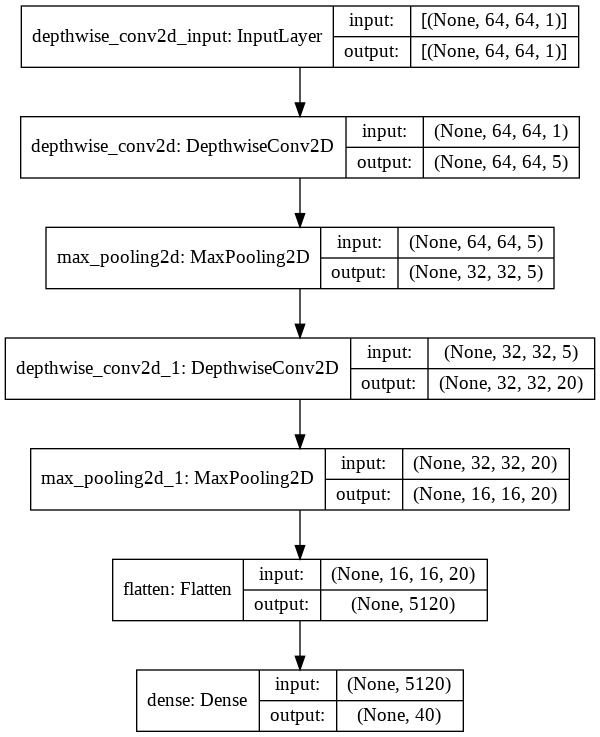

In [ ]:
# CELL 12 - SAVE THE MODEL 
#--------------------------------------
# SAVING and visualising model 
#-----------------------------------------------------------
nume_dorit='lb_cnn_orl_100_00'  # Desired name for the file 
model.save(nume_dorit+'.h5')  
#tf.keras.models.save_model(model,'tmp.h5')
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=nume_dorit+'.png', show_shapes=True, show_layer_names=True, dpi=96)